# Strava Fitness Data Analytics Case Study

### Submitted by Aswathy Gopalakrishnan

The initial statistical analysis have alrady been done in SQL. Further analysis in detail, and visualisation analysis to derive in-depth insights are done here

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.getcwd()

'c:\\Users\\USER\\Desktop\\Strava Fitness EDA'

The main files for analysis has undergone formatting and cleaning in the SQL phase. Files are loaded here for remaining tasks. Two additional files monthly and weekly activity summary made in SQL are also used here.

## Data Preprocessing

In [2]:

# Loading data
df_dailyactivity = pd.read_csv('./data/dailyActivity_merged.csv')
df_sleepday = pd.read_csv('./data/sleepDay_merged.csv')
df_monthlyactivity = pd.read_csv('./data/monthly_activity_summary.csv')
df_weeklyactivity = pd.read_csv('./data/weekly_activity_summary.csv')

df_hourlycalories = pd.read_csv('./data/hourlyCalories_merged.csv')
df_hourlyintensities = pd.read_csv('./data/hourlyIntensities_merged.csv')
df_hourlysteps = pd.read_csv('./data/hourlySteps_merged.csv')

df_minutecaloriesnarrow = pd.read_csv('./data/minuteCaloriesNarrow_merged.csv')
df_minuteintensitiesnarrow = pd.read_csv('./data/minuteIntensitiesNarrow_merged.csv')
df_minuteMETsnarrow = pd.read_csv('./data/minuteMETsNarrow_merged.csv')
df_minutesleep = pd.read_csv('./data/minuteSleep_merged.csv')
df_minutestepsnarrow = pd.read_csv('./data/minuteStepsNarrow_merged.csv')

df_heartrateseconds = pd.read_csv('./data/heartrate_seconds_merged.csv')

In [3]:
# # Making sure the dates are rightly formatted
df_dailyactivity['ActivityDate'] = pd.to_datetime(df_dailyactivity['ActivityDate'], errors='coerce')
df_sleepday['SleepDay'] = pd.to_datetime(df_sleepday['SleepDay'], errors='coerce')

C:\Users\USER\AppData\Local\Temp\ipykernel_15416\1911488339.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sleepday['SleepDay'] = pd.to_datetime(df_sleepday['SleepDay'], errors='coerce')


The dataframes are loaded. The minute datasets were not considered for evaluation on SQl. So, their dates are still in text format. It has to be converted to datetimeformat

Now, Let's combine the minute datas into one dataframe for easy analysis and comparisson

In [4]:
#merging minutes data to one df for analysis
df_minutesactivitynarrow = df_minutecaloriesnarrow
df_minutesactivitynarrow = pd.merge(df_minutesactivitynarrow, df_minuteintensitiesnarrow, on=['Id', 'ActivityMinute'], how='outer')
df_minutesactivitynarrow = pd.merge(df_minutesactivitynarrow, df_minutestepsnarrow, on=['Id', 'ActivityMinute'], how='outer')
df_minutesactivitynarrow = pd.merge(df_minutesactivitynarrow, df_minuteMETsnarrow, on=['Id', 'ActivityMinute'], how='outer')
df_minuteactivitynarrow = df_minutesactivitynarrow
df_minuteactivitynarrow.head()

,Id,ActivityMinute,Calories,Intensity,Steps,METs
0,1503960366,4/12/2016 10:00:00 AM,0.9438,0,0,12
1,1503960366,4/12/2016 10:00:00 PM,1.8876,1,6,24
2,1503960366,4/12/2016 10:01:00 AM,0.9438,0,0,12
3,1503960366,4/12/2016 10:01:00 PM,1.8876,1,2,24
4,1503960366,4/12/2016 10:02:00 AM,2.5168,1,31,32


Converting the ActivityMinute column to DateTime format

In [5]:
df_minutesactivitynarrow['ActivityMinute'] = pd.to_datetime(df_minutesactivitynarrow['ActivityMinute'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
df_minutesactivitynarrow.head()

,Id,ActivityMinute,Calories,Intensity,Steps,METs
0,1503960366,2016-04-12 10:00:00,0.9438,0,0,12
1,1503960366,2016-04-12 22:00:00,1.8876,1,6,24
2,1503960366,2016-04-12 10:01:00,0.9438,0,0,12
3,1503960366,2016-04-12 22:01:00,1.8876,1,2,24
4,1503960366,2016-04-12 10:02:00,2.5168,1,31,32


Converting the Time column in heartrate seconds dataframe to datetime format

In [6]:
df_heartrateseconds['Time'] = pd.to_datetime(df_heartrateseconds['Time'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
df_heartrateseconds.dtypes

Id                int64
Time     datetime64[ns]
Value             int64
dtype: object

## Analysis and Visualization of Data

### Analysing sleep and daily activity correlation

The sleep patterns are analysed against the daily activity to identify the correlation between them.

In [7]:
df_dailyactivity['date'] = df_dailyactivity['ActivityDate'].dt.date
df_sleepday['date'] = df_sleepday['SleepDay'].dt.date

df_dailyactivity_and_sleep = pd.merge(
    df_dailyactivity,
    df_sleepday,
    on=['Id', 'date'],
    how='inner'
)

correlation = df_dailyactivity_and_sleep['TotalSteps'].corr(df_dailyactivity_and_sleep['TotalMinutesAsleep'])
print('Correlation between Total Steps and Minutes Asleep:', correlation)

Correlation between Total Steps and Minutes Asleep: -0.18686649892545953


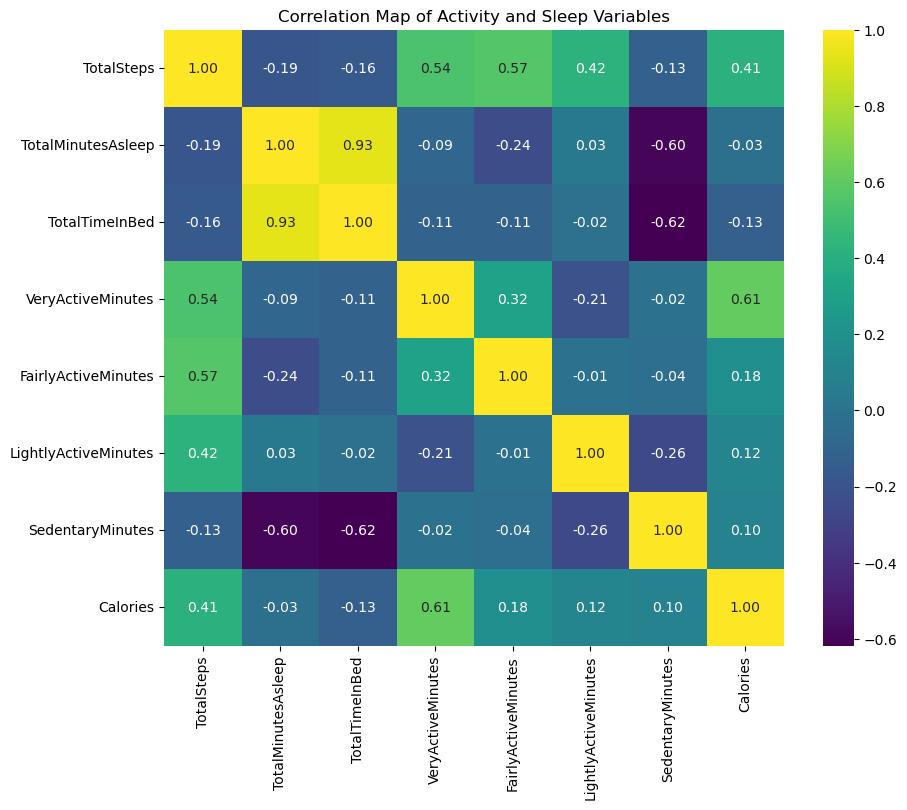

In [8]:
# Calculate the correlation matrix for selected columns
corr_matrix = df_dailyactivity_and_sleep[['TotalSteps', 'TotalMinutesAsleep', 'TotalTimeInBed','VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f')

plt.title('Correlation Map of Activity and Sleep Variables')
plt.show()

The correlation is negative for the activities and sleep

From both the analysis, it is clear that there is almost no linear relationship between the activity and sleep data. This could be because of various other factors which are not available in the dataset; for instance - age, gender, profession, etc. Previously on SQL, it has already been analysed with the sleep next day. Even then, there was no direct correlation. This indicates that we require more data to suggest good sleeping patterns to the user.

### Analysing correlation between METs and sleep

In [9]:
daily_METs = df_minuteMETsnarrow.groupby(['Id', 'ActivityMinute'])['METs'].mean().reset_index()

daily_sleep = df_minutesleep.groupby(['Id', 'date'])['value'].sum().reset_index()

merged_data = pd.merge(daily_METs, daily_sleep, left_on=['Id', 'ActivityMinute'], right_on=['Id', 'date'])
print(merged_data[['METs', 'value']].corr())

           METs     value
METs   1.000000  0.347416
value  0.347416  1.000000


The correlation coefficient is approx. 0.35 between METs and sleep value. This means there is a moderate positive correlation. MET stands for Metabolic Equivalent of Task. It is a unit used to estimate the amount of energy expenditure during physical activity compared to resting metabolic rate. In simple terms,an activity with a MET value of 3 means you are burning three times more energy than when at rest. Activities are usually categorized by METs based on their intensity: light, moderate, or vigorous. for instance,	sitting quietly is below 1.5 MET, walking at a moderate pace is about 3-6 METs, and running or intense activity: often 6+ METs. So, if there is a high intensity workout performed, the user can be exhausted and can have a better sleep. So, suggesting high intensity workout to help with sleep improvement can be consisdered. However, this needs to be done considering the age, gender, and physical limitations of the user.


### Analysing the most active days 

An additional weekday column is created to analyse how the activity is over different days of the week. This can help in providing more motivational inputs on days that lack activity

In [10]:
df_dailyactivity['Weekday'] = df_dailyactivity['ActivityDate'].dt.weekday
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_dailyactivity['WeekdayName'] = df_dailyactivity['Weekday'].map(weekday_map)

# Aggregate total steps per weekday
weekday_steps = df_dailyactivity.groupby('WeekdayName')['TotalSteps'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


C:\Users\USER\AppData\Local\Temp\ipykernel_15416\3475586507.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=weekday_steps.index, y=weekday_steps.values, palette='viridis')


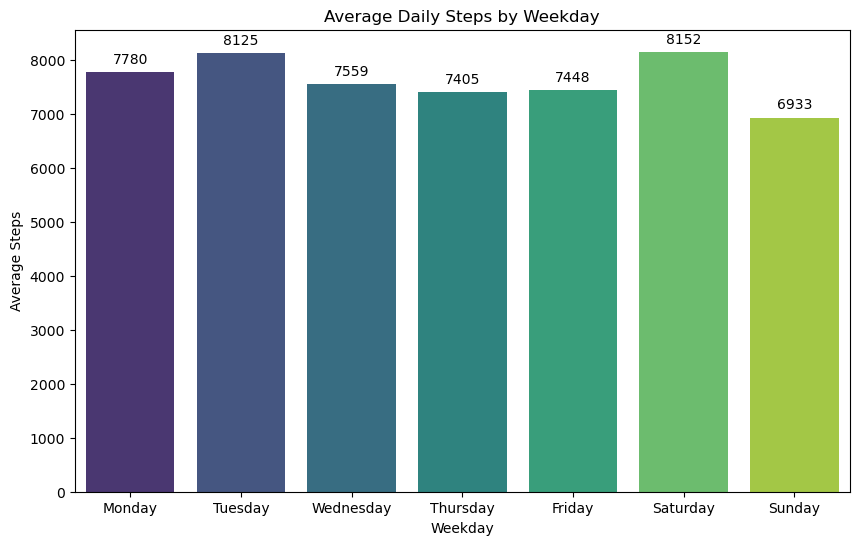

In [11]:
# Plot the graph
plt.figure(figsize=(10,6))
ax = sns.barplot(x=weekday_steps.index, y=weekday_steps.values, palette='viridis')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + max(weekday_steps.values)*0.02, f'{int(height)}', ha='center')

plt.title('Average Daily Steps by Weekday')
plt.ylabel('Average Steps')
plt.xlabel('Weekday')
plt.show()


From the analysis, it is observed that Sundays have the lowest activity with 6933 steps, and the highest is on Saturdays and Tuesdays with 8152 and 8125 average steps respectively.

### Analysing individual user activity on weekdays 

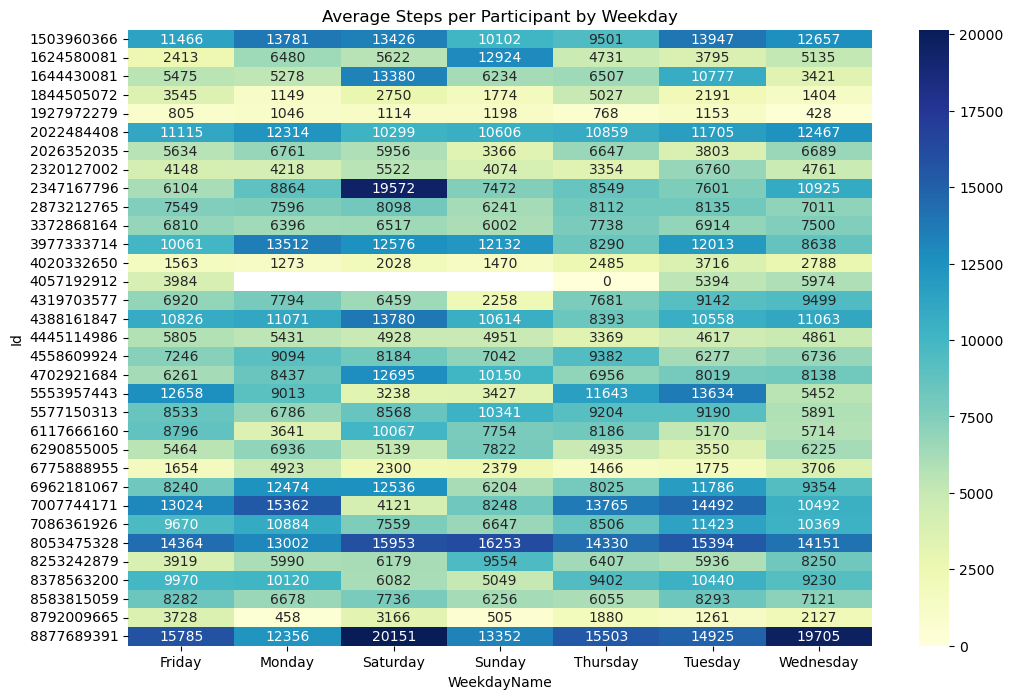

In [12]:
pivot_table = df_dailyactivity.pivot_table(index='Id', columns='WeekdayName', values='TotalSteps', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='YlGnBu', cbar=True)
plt.title('Average Steps per Participant by Weekday')
plt.show()


From the heatmap, it can be observed that, some users have consistently high activity across the week. Even they have their highest on tuesday and saturday mostly. Some of the users have consistently low usage across the week indicating that they aren't using the tracker properly. A dip in the mid-week can also be observed which could be due to work related commitments. Suggestions to do brisk activities during these periods can engage the user in using the tracker and still keeping the steps consistent. Sundays are the lowest as most users take a break and engage in leisurely activities that day. This can be changed into a rest day or low activity day to improve the motivation on mondays.

### Analysing average sedentary minutes per user per weekday

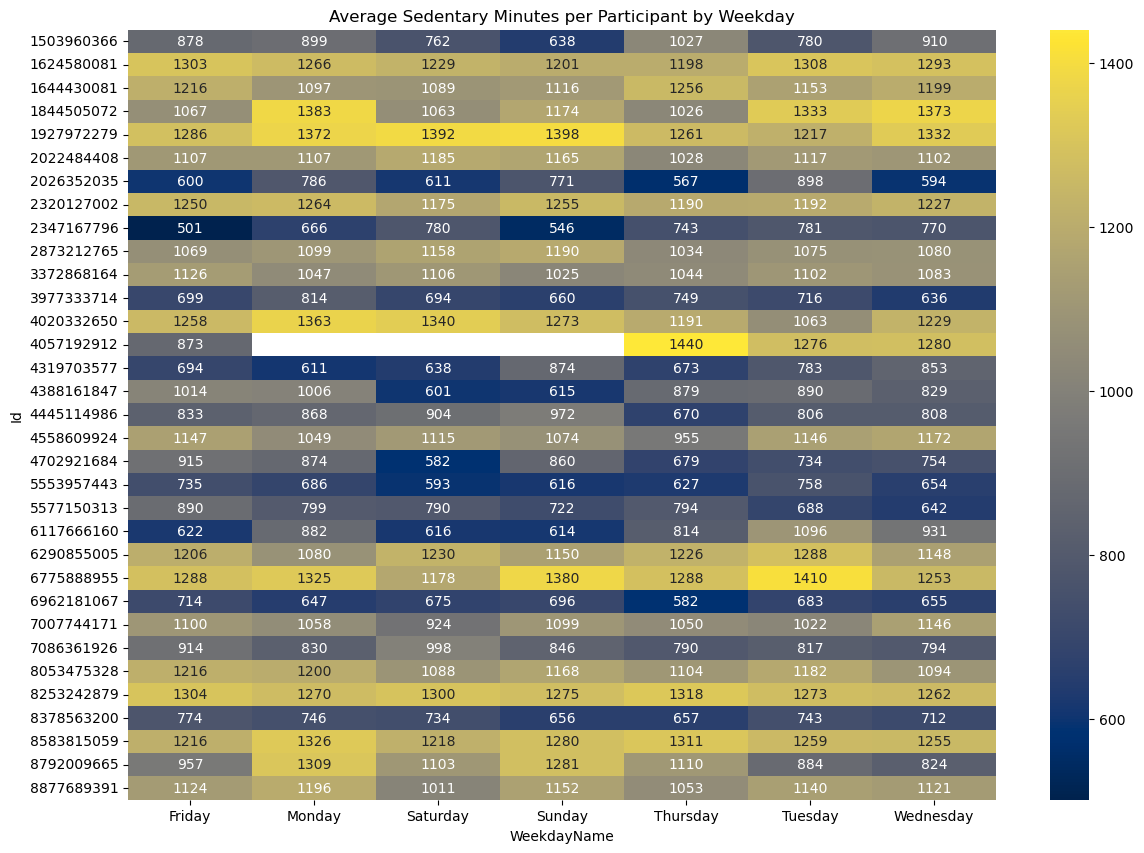

In [13]:
pivot_sedentary = df_dailyactivity.pivot_table(
    index='Id',
    columns='WeekdayName',
    values='SedentaryMinutes'
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_sedentary, annot=True, fmt=".0f", cmap='cividis', cbar=True)
plt.title('Average Sedentary Minutes per Participant by Weekday')
plt.show()


The users with really high sedentary minutes close to 1400 (almost equal to 24 hrs a day) on all days may not be wearing it throughout the day. There must be some sensor to verif this. additionally, user can be notified via mail or text to use the tracker. Also, the blue shaded columns show the ones with lowest sedentary minutes. They must be wearing it throughout day and night. This way, their sleep is also monitored properly. Motivate the users to do this to get better data to improve sleep related insights too.

### Analysing the calories burned by the user on weekday basis

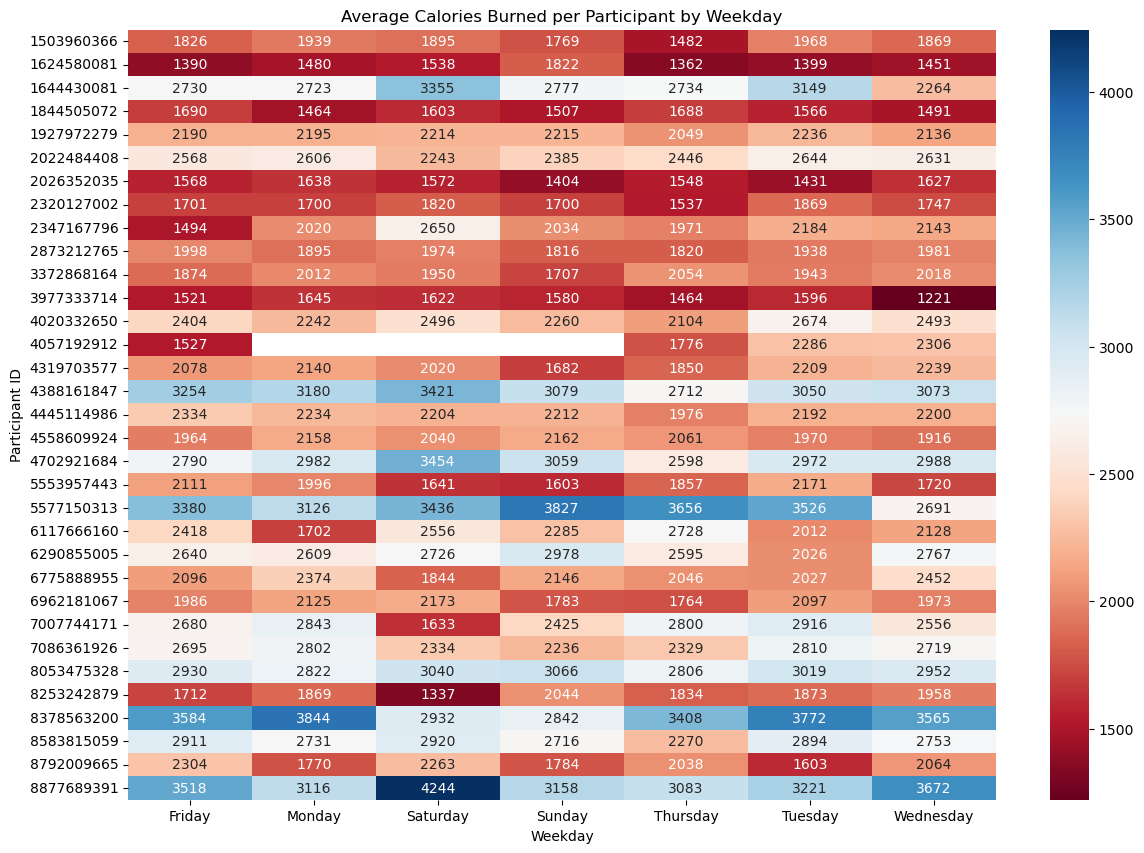

In [14]:
pivot_calories = df_dailyactivity.pivot_table(
    index='Id',
    columns='WeekdayName',
    values='Calories',
    aggfunc='mean'
)


plt.figure(figsize=(14, 10))
sns.heatmap(pivot_calories, annot=True, fmt=".0f", cmap='RdBu', cbar=True)

plt.title('Average Calories Burned per Participant by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Participant ID')

plt.show()

The results are obvious. The one who are consistent in using the tracker and have high average steps burn higher calories. However, most of them burn the minimum requirement of calories for an average adult which is good. The calories burned really doesn't matter according to the harvard university studies. The calorie intake is what matters. If the user is taking extra calories, they need to minimize that or do extra activity to burn them. Without the information on calorie intake, this analysis won't be complete. Stakeholders need to be informed so as to include this information along with the other missing details.

### Analysis of correlation between heartrate and intensity of workout

In [15]:

df_heartrateseconds['Time'] = pd.to_datetime(df_heartrateseconds['Time'])

# Creating a 'minute' column for grouping
df_heartrateseconds['Minute'] = df_heartrateseconds['Time'].dt.floor('T') 

# Aggregating mean heart rate per minute for each user
hr_per_minute = df_heartrateseconds.groupby(['Id', 'Minute'])['Value'].mean().reset_index()


C:\Users\USER\AppData\Local\Temp\ipykernel_15416\4094091741.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_heartrateseconds['Minute'] = df_heartrateseconds['Time'].dt.floor('T')


C:\Users\USER\AppData\Local\Temp\ipykernel_15416\3378509412.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_minuteintensitiesnarrow['ActivityMinute'] = pd.to_datetime(df_minuteintensitiesnarrow['ActivityMinute'])


              Value  Intensity
Value      1.000000   0.690277
Intensity  0.690277   1.000000


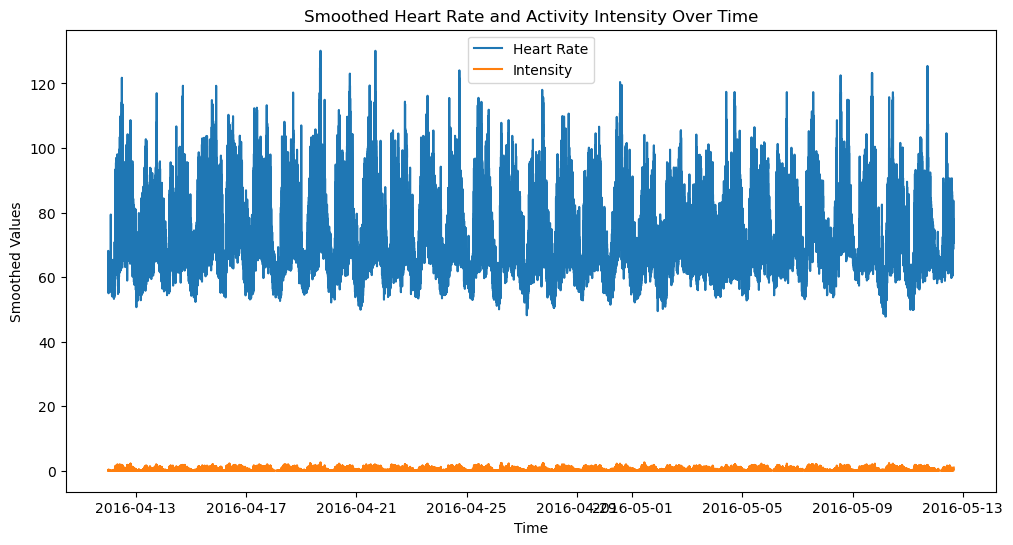

In [16]:
hr_per_minute['Minute'] = pd.to_datetime(hr_per_minute['Minute'])
df_minuteintensitiesnarrow['ActivityMinute'] = pd.to_datetime(df_minuteintensitiesnarrow['ActivityMinute'])

# Merging
merged_df = pd.merge(
    hr_per_minute,
    df_minuteintensitiesnarrow,
    left_on=['Id', 'Minute'],
    right_on=['Id', 'ActivityMinute'],
    how='inner' 
)


print(merged_df[['Value', 'Intensity']].corr())

merged_df_sorted = merged_df.sort_values('Minute')

# Calculate rolling mean 
merged_df_sorted['heart_rate_smooth'] = merged_df_sorted['Value'].rolling(window=5).mean()
merged_df_sorted['intensity_smooth'] = merged_df_sorted['Intensity'].rolling(window=5).mean()

plt.figure(figsize=(12,6))
plt.plot(merged_df_sorted['Minute'], merged_df_sorted['heart_rate_smooth'], label='Heart Rate')
plt.plot(merged_df_sorted['Minute'], merged_df_sorted['intensity_smooth'], label='Intensity')
plt.xlabel('Time')
plt.ylabel('Smoothed Values')
plt.title('Smoothed Heart Rate and Activity Intensity Over Time')
plt.legend()
plt.show()


The heart rate and intensity per minute shows a moderate to strong positive correlation of 0.69, indicating that the heart rate increases with increase in intensity and the values taken by the tracker is right. This is helpful in giving useful insights to the user. according to the harvard studies, for a 40-year-old person with a maximum heart rate of 180, the target heart rate falls somewhere between 117-135 beats per minute for moderate exercise, or 139-167 for vigorous exercise. So, if there is some setting to track the heart beat and notify the user in case of any abnormalities, that would be helpful. Strava fitness uses a third party ring to track the heartrates. Not all user may have this. This is probably why there aren't much features on the app to monitor the heartbeat. however, keeping track of the heartbeat and consistently checking for abnormalities would be helpful to detect heart problems earlier (similar to the apple watch feature).

### Preparing Data for Power BI

Saving the updated datasets for further visualizations that will be done on Power BI.

In [17]:
df_dailyactivity.to_csv('./data/dailyActivity_updated.csv', index=False)
df_dailyactivity_and_sleep.to_csv('./Data/dailyactivityandsleep_updated.csv', index=False)
df_minuteintensitiesnarrow.to_csv('./Data/minuteintensities_updated.csv', index=False)
df_minuteMETsnarrow.to_csv('./Data/minuteMETs_updated.csv', index=False)
df_sleepday.to_csv('./Data/sleepday_updated.csv', index=False)
df_minutesleep.to_csv('./Data/minutesleep_updated.csv', index=False)
df_heartrateseconds.to_csv('./Data/heartrateseconds_updated.csv', index=False)
df_minuteactivitynarrow.to_csv('./Data/minuteactivitymerged_updated.csv', index=False)

In [18]:
df_hourlycalories['ActivityHour'] = pd.to_datetime(df_hourlycalories['ActivityHour'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
df_hourlyintensities['ActivityHour'] = pd.to_datetime(df_hourlyintensities['ActivityHour'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
df_hourlysteps['ActivityHour'] = pd.to_datetime(df_hourlysteps['ActivityHour'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
df_hourlycalories.to_csv('./Data/hourlycalories_updated.csv', index=False)
df_hourlyintensities.to_csv('./Data/hourlyintensities_updated.csv', index=False)
df_hourlysteps.to_csv('./Data/hourlysteps_updated.csv', index=False)